In [2]:
import numpy as np

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from neuralforecast import NeuralForecast
from neuralforecast.models import MLP, Autoformer
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss
from neuralforecast.tsdataset import TimeSeriesDataset
from neuralforecast.utils import AirPassengers, AirPassengersPanel, AirPassengersStatic, augment_calendar_df

from neuralforecast.losses.pytorch import MAE
import time
import datetime
from sklearn.preprocessing import MinMaxScaler

python -u run.py  --is_training 1 --root_path ./datasets/ --data_path data_step=60_train=0.9.csv --model_id qber1   --model Autoformer   --data custom   --features M   --seq_len 96 --label_len 48 --pred_len 24 --e_layers 2 --d_layers 1 --factor 3 --enc_in 6 --dec_in 6 --c_out 6 --des 'Exp' --itr 1  --train_epochs 3 --moving_avg 25 --use_gpu 1 --batch_size 64

In [18]:
pd.read_csv('datasets/data_step=60_train=0.9.csv')


,OT,0,1,2,3,4,date
0,0.01298,0.01904,0.17794,0.550377,0.164911,0.008094,1970-01-01 03:00:00
1,0.01283,0.01672,0.20868,0.564295,0.167629,0.006639,1970-01-01 03:01:00
2,0.01268,0.01337,0.20442,0.564179,0.164110,0.007052,1970-01-01 03:02:00
3,0.01129,0.01637,0.18453,0.573555,0.167174,0.006663,1970-01-01 03:03:00
4,0.01169,0.01783,0.11478,0.569296,0.169658,0.006823,1970-01-01 03:04:00
...,...,...,...,...,...,...,...
166360,0.00963,0.01398,0.12413,0.571324,0.169381,0.007646,1970-04-26 15:40:00
166361,0.00952,0.01519,0.18354,0.571041,0.170263,0.007222,1970-04-26 15:41:00
166362,0.01015,0.01697,0.22703,0.568009,0.169526,0.009021,1970-04-26 15:42:00
166363,0.01129,0.01408,0.16103,0.566529,0.169750,0.007831,1970-04-26 15:43:00


In [5]:
def get_ds(index,start_ts=0,step=60):
    index_tmp=index*step+start_ts
    date=datetime.datetime.fromtimestamp(index_tmp).strftime('%Y-%m-%d %H:%M:%S')
    date=pd.Timestamp(date)
    return date

In [3]:
# def get_norm_time(index):
#     return scaler.transform([[index]])

In [13]:
df=pd.read_csv('datasets/data.csv')
# df=df.drop(['id','e_mu_estimated'],axis=1)
# df['unique_id']=1
df=df.rename(columns={'e_mu_current':'OT'})
df=df.rename(columns={'e_nu_1':'0'})
df=df.rename(columns={'e_nu_2':'1'})
df=df.rename(columns={'q_mu':'2'})
df=df.rename(columns={'q_nu1':'3'})
df=df.rename(columns={'q_nu2':'4'})
df['index']=range(df.__len__())
df['date']=df['index'].map(get_ds)

# scaler = MinMaxScaler((-1,1))
# scaler.fit(np.arange(df.__len__()).reshape((-1,1)))
# df['ts_norm']=df['index'].map(get_norm_time)

del df['index']
del df['id']

df

,OT,0,1,2,3,4,date
0,0.01298,0.01904,0.17794,0.550377,0.164911,0.008094,1970-01-01 03:00:00
1,0.01283,0.01672,0.20868,0.564295,0.167629,0.006639,1970-01-01 03:01:00
2,0.01268,0.01337,0.20442,0.564179,0.164110,0.007052,1970-01-01 03:02:00
3,0.01129,0.01637,0.18453,0.573555,0.167174,0.006663,1970-01-01 03:03:00
4,0.01169,0.01783,0.11478,0.569296,0.169658,0.006823,1970-01-01 03:04:00
...,...,...,...,...,...,...,...
184845,0.00842,0.02085,0.25589,0.566484,0.172819,0.008164,1970-05-09 11:45:00
184846,0.00971,0.01592,0.23668,0.572031,0.170474,0.007907,1970-05-09 11:46:00
184847,0.00886,0.01590,0.24216,0.569204,0.173147,0.007366,1970-05-09 11:47:00
184848,0.00868,0.01384,0.24447,0.570114,0.168854,0.007378,1970-05-09 11:48:00


In [15]:
0.1*len(df)

18485.0

In [17]:
df.iloc[:-18485].to_csv('datasets/data_step=60_train=0.9.csv',index=False,)

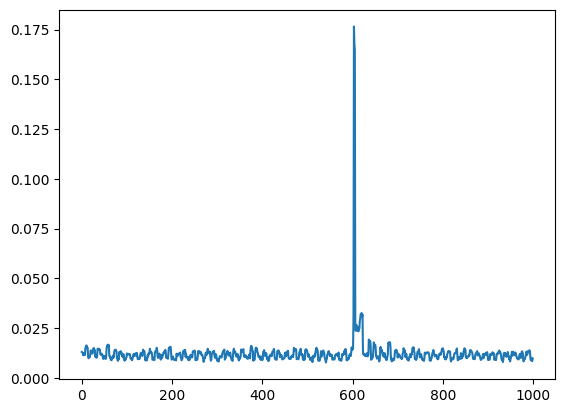

In [18]:
start=0
end=1000

plt.plot(df['y'][start:end])
plt.show()

In [139]:

AirPassengersPaneld, calendar_cols = augment_calendar_df(df=AirPassengersPanel, freq='M')

Y_train_df = AirPassengersPaneld[AirPassengersPaneld.ds<AirPassengersPaneld['ds'].values[-12]] # 132 train
Y_test_df = AirPassengersPaneld[AirPassengersPaneld.ds>=AirPassengersPaneld['ds'].values[-12]].reset_index(drop=True) # 12 test

# Y_train_df=Y_train_df.drop(['ds','trend','y_[lag12]'],axis=1)
# Y_test_df=Y_test_df.drop(['ds','trend','y_[lag12]'],axis=1)

print(calendar_cols)

['month']


In [126]:
N=20
series_length=500

indices=list(np.random.choice(range(df.__len__()),N))
indices.extend([0])

test_df=[]
for index in indices:
    test_df.extend(df.iloc[index:index+series_length].values)

test_df=pd.DataFrame(test_df,columns=df.columns)
train_df=pd.merge(df, test_df, on='index', how="outer", indicator=True)
train_df=train_df[train_df['_merge'] == 'left_only'].dropna(axis=1)
train_df=train_df.rename(columns={'y_x':'y',
                                  'e_nu_1_x':'e_nu_1',
                                  'e_nu_2_x':'e_nu_2',
                                  'q_mu_x':'q_mu',
                                  'q_nu1_x':'q_nu1',
                                  'q_nu2_x':'q_nu2',
                                  'unique_id_x':'unique_id',
                                  'ds_x':'ds'})
del train_df['_merge']

In [127]:
test_df

,y,e_nu_1,e_nu_2,q_mu,q_nu1,q_nu2,unique_id,index,ds
0,0.01919,0.02317,0.18454,0.595880,0.185818,0.008894,1,153075,1970-04-17 10:15:00
1,0.01621,0.02298,0.27073,0.597678,0.172536,0.008789,1,153076,1970-04-17 10:16:00
2,0.01419,0.02288,0.22842,0.591721,0.177821,0.008789,1,153077,1970-04-17 10:17:00
3,0.01886,0.02384,0.15862,0.587967,0.184258,0.008128,1,153078,1970-04-17 10:18:00
4,0.02048,0.04322,0.24223,0.594698,0.177666,0.007434,1,153079,1970-04-17 10:19:00
...,...,...,...,...,...,...,...,...,...
10495,0.01382,0.01633,0.12579,0.566309,0.173391,0.007037,1,495,1970-01-01 11:15:00
10496,0.01426,0.01312,0.16843,0.565940,0.171863,0.007324,1,496,1970-01-01 11:16:00
10497,0.01434,0.01363,0.14489,0.567090,0.174047,0.007881,1,497,1970-01-01 11:17:00
10498,0.01371,0.01535,0.15649,0.560413,0.171420,0.006676,1,498,1970-01-01 11:18:00


In [128]:
train_df

,y,e_nu_1,e_nu_2,q_mu,q_nu1,q_nu2,unique_id,index,ds
500,0.01250,0.01468,0.11295,0.570140,0.169449,0.006791,1,500,1970-01-01 11:20:00
501,0.01063,0.01510,0.15049,0.562768,0.170320,0.007490,1,501,1970-01-01 11:21:00
502,0.01136,0.01569,0.18160,0.568755,0.169999,0.007026,1,502,1970-01-01 11:22:00
503,0.01176,0.01562,0.15873,0.569499,0.163940,0.007119,1,503,1970-01-01 11:23:00
504,0.01051,0.01796,0.21062,0.563328,0.168708,0.007373,1,504,1970-01-01 11:24:00
...,...,...,...,...,...,...,...,...,...
185352,0.00842,0.02085,0.25589,0.566484,0.172819,0.008164,1,184845,1970-05-09 11:45:00
185353,0.00971,0.01592,0.23668,0.572031,0.170474,0.007907,1,184846,1970-05-09 11:46:00
185354,0.00886,0.01590,0.24216,0.569204,0.173147,0.007366,1,184847,1970-05-09 11:47:00
185355,0.00868,0.01384,0.24447,0.570114,0.168854,0.007378,1,184848,1970-05-09 11:48:00


In [155]:

model = Autoformer(h=12,
                 input_size=24,
                 hidden_size = 16,
                 conv_hidden_size = 32,
                 n_head=2,
                 loss=MAE(),
                 futr_exog_list=['e_nu_1','e_nu_2','q_mu','q_nu1','q_nu2'],
                 # futr_exog_list=['month'],
                 scaler_type='robust',
                 learning_rate=1e-3,
                 max_steps=300,
                 val_check_steps=50,
                 early_stop_patience_steps=2)\

nf = NeuralForecast(
    models=[model],
    freq='S'
    # freq='M'
)

Global seed set to 1


In [158]:
AirPassengersStatic

,unique_id,airline1,airline2
0,Airline1,0,1
1,Airline2,1,0


In [162]:
static_df=pd.DataFrame({'unique_id':[1], '1':[1]})
static_df

,unique_id,1
0,1,1


In [163]:
# nf.fit(df=Y_train_df, static_df=AirPassengersStatic, val_size=12)
nf.fit(df=train_df, static_df=static_df, val_size=12)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [179]:
forecasts = nf.predict(test_df)
forecasts

Predicting: 0it [00:00, ?it/s]

,ds,Autoformer
unique_id,,
1,1970-05-02 20:22:01,0.012161
1,1970-05-02 20:22:02,0.012168
1,1970-05-02 20:22:03,0.012195
1,1970-05-02 20:22:04,0.012132
1,1970-05-02 20:22:05,0.012049
1,1970-05-02 20:22:06,0.011984
1,1970-05-02 20:22:07,0.011942
1,1970-05-02 20:22:08,0.011859
1,1970-05-02 20:22:09,0.011767


In [180]:
test_df

,y,e_nu_1,e_nu_2,q_mu,q_nu1,q_nu2,unique_id,index,ds
0,0.01919,0.02317,0.18454,0.595880,0.185818,0.008894,1,153075,1970-04-17 10:15:00
1,0.01621,0.02298,0.27073,0.597678,0.172536,0.008789,1,153076,1970-04-17 10:16:00
2,0.01419,0.02288,0.22842,0.591721,0.177821,0.008789,1,153077,1970-04-17 10:17:00
3,0.01886,0.02384,0.15862,0.587967,0.184258,0.008128,1,153078,1970-04-17 10:18:00
4,0.02048,0.04322,0.24223,0.594698,0.177666,0.007434,1,153079,1970-04-17 10:19:00
...,...,...,...,...,...,...,...,...,...
10495,0.01382,0.01633,0.12579,0.566309,0.173391,0.007037,1,495,1970-01-01 11:15:00
10496,0.01426,0.01312,0.16843,0.565940,0.171863,0.007324,1,496,1970-01-01 11:16:00
10497,0.01434,0.01363,0.14489,0.567090,0.174047,0.007881,1,497,1970-01-01 11:17:00
10498,0.01371,0.01535,0.15649,0.560413,0.171420,0.006676,1,498,1970-01-01 11:18:00


In [133]:
Y_test_df

,unique_id,ds,y,trend,y_[lag12],month
0,Airline1,1960-01-31,417.0,132,360.0,-0.500000
1,Airline1,1960-02-29,391.0,133,342.0,-0.409091
2,Airline1,1960-03-31,419.0,134,406.0,-0.318182
3,Airline1,1960-04-30,461.0,135,396.0,-0.227273
4,Airline1,1960-05-31,472.0,136,420.0,-0.136364
5,Airline1,1960-06-30,535.0,137,472.0,-0.045455
6,Airline1,1960-07-31,622.0,138,548.0,0.045455
7,Airline1,1960-08-31,606.0,139,559.0,0.136364
8,Airline1,1960-09-30,508.0,140,463.0,0.227273
9,Airline1,1960-10-31,461.0,141,407.0,0.318182


In [53]:
forecasts

,ds,Autoformer
unique_id,,
Airline1,1960-01-31,407.213226
Airline1,1960-02-29,408.232025
Airline1,1960-03-31,447.086182
Airline1,1960-04-30,448.556549
Airline1,1960-05-31,453.166901
Airline1,1960-06-30,503.543854
Airline1,1960-07-31,591.610657
Airline1,1960-08-31,605.109619
Airline1,1960-09-30,530.382874


In [174]:
Y_hat_df = forecasts.reset_index(drop=False).drop(columns=['unique_id','ds'])
plot_df = pd.concat([test_df, Y_hat_df], axis=1)
plot_df = pd.concat([train_df, plot_df])

# plot_df = plot_df[plot_df.unique_id=='Airline1'].drop('unique_id', axis=1)

In [175]:
plot_df

,y,e_nu_1,e_nu_2,q_mu,q_nu1,q_nu2,unique_id,index,ds,Autoformer
500,0.01250,0.01468,0.11295,0.570140,0.169449,0.006791,1,500,1970-01-01 11:20:00,NaN
501,0.01063,0.01510,0.15049,0.562768,0.170320,0.007490,1,501,1970-01-01 11:21:00,NaN
502,0.01136,0.01569,0.18160,0.568755,0.169999,0.007026,1,502,1970-01-01 11:22:00,NaN
503,0.01176,0.01562,0.15873,0.569499,0.163940,0.007119,1,503,1970-01-01 11:23:00,NaN
504,0.01051,0.01796,0.21062,0.563328,0.168708,0.007373,1,504,1970-01-01 11:24:00,NaN
...,...,...,...,...,...,...,...,...,...,...
10495,0.01382,0.01633,0.12579,0.566309,0.173391,0.007037,1,495,1970-01-01 11:15:00,NaN
10496,0.01426,0.01312,0.16843,0.565940,0.171863,0.007324,1,496,1970-01-01 11:16:00,NaN
10497,0.01434,0.01363,0.14489,0.567090,0.174047,0.007881,1,497,1970-01-01 11:17:00,NaN
10498,0.01371,0.01535,0.15649,0.560413,0.171420,0.006676,1,498,1970-01-01 11:18:00,NaN


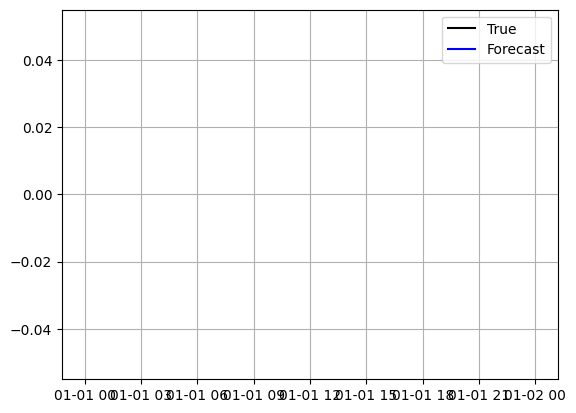

In [177]:
Y_hat_df = forecasts.reset_index(drop=False).drop(columns=['unique_id','ds'])
plot_df = pd.concat([test_df, Y_hat_df], axis=1)
plot_df = pd.concat([train_df, plot_df])

plot_df = plot_df[plot_df.unique_id=='Airline2'].drop('unique_id', axis=1)

plt.plot(plot_df['ds'], plot_df['y'], c='black', label='True')
# plt.plot(plot_df['y'].values, c='black', label='True')
plt.plot(plot_df['ds'], plot_df['Autoformer'], c='blue', label='Forecast')

plt.legend()
plt.grid()
plt.show()


In [178]:
plot_df['Autoformer']

Series([], Name: Autoformer, dtype: float64)